In [ ]:
import numpy as np
import datetime


import matplotlib.pyplot as plt
from PIL import Image

from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from numpy.linalg import norm
from sklearn.feature_extraction import image
import warnings
warnings.filterwarnings("ignore")


In [2]:
def get_B_and_weight_vec(n_nodes,threshold,sigma=1):
    '''
    Generate graph structure from the image to be segmented.
    Inputs:
        n_nodes: number of nodes, i.e. number of pixels
        threshold: threshold to drop edges with small weights (weak similarities)
        sigma: parameter to scale edge weights
    Outputs:
        B: Incidence matrix
        Weight_vec: edge_wise weights
    '''
    N = n_nodes
    row = []
    col = []
    data = []
    weight_vec = []
    cnt = 0
#     
    for i in range(N):
        for j in [i+1,i+100]:
            if j>=2900:
                continue
            if  np.exp(-norm(img[i]-img[j])/(2*sigma**2)) > threshold:
                row.append(cnt)
                col.append(i)
                data.append(1)

                row.append(cnt)
                col.append(j)
                data.append(-1)
                cnt += 1
                weight_vec.append(np.exp(-norm(img[i]-img[j])/(2*sigma**2)))

    B = csr_matrix((data, (row, col)), shape=(cnt, N))
    weight_vec = np.array(weight_vec)
    return B, weight_vec

In [17]:
def algorithm(B, weight_vec, seeds,K=15000,alpha=0.02, lambda_nLasso=None, check_s=False):
    E, N = B.shape
#     weight_vec = np.ones(E)

    Gamma_vec = np.array(1./(np.sum(abs(B), 0)))[0]  # \in [0, 1]
    Gamma = np.diag(Gamma_vec)

    Sigma = 0.5

    seednodesindicator= np.zeros(N)
    seednodesindicator[seeds] = 1        


    
    noseednodeindicator = np.ones(N)
    noseednodeindicator[seeds] = 0
    
    if lambda_nLasso == None:
        lambda_nLasso = 2 / math.sqrt(np.sum(weight_vec))
    
    if check_s:
        s = 0.0
        for item in range(len(weight_vec)):
            x = B[item].toarray()[0]
            i = np.where(x == -1)[0][0]
            j = np.where(x == 1)[0][0]
            if i < N1 <= j:
                s += weight_vec[item]
            elif i >= N1 > j:
                s += weight_vec[item]

        if lambda_nLasso * s >= alpha * N2 / 2:
            print ('eq(24)', lambda_nLasso * s, alpha * N2 / 2)
    
    fac_alpha = 1./(Gamma_vec*alpha+1)  # \in [0, 1]

    hatx = np.zeros(N)
    newx = np.zeros(N)
    prevx = np.zeros(N)
    haty = np.array([x/(E-1) for x in range(0, E)])
    history = []
    for iterk in range(K):
        # if 0 < np.max(abs(newx - prevx)) < 1e-4:
        #     print(iterk)
        #     break
        tildex = 2 * hatx - prevx
        newy = haty + Sigma * B.dot(tildex)  # chould be negative
        haty = newy / np.maximum(abs(newy) / (lambda_nLasso * weight_vec), np.ones(E))  # could be negative

        newx = hatx - Gamma_vec * B.T.dot(haty)  # could  be negative
        newx[seeds] = (newx[seeds] + Gamma_vec[seeds]) / (1 + Gamma_vec[seeds])

        newx = seednodesindicator * newx + noseednodeindicator * (newx * fac_alpha)
        prevx = np.copy(hatx)
        hatx = newx  # could be negative
        history.append(newx)
    
    history = np.array(history)

    return history
       

In [26]:
#load the image
img=Image.open("stripes.png")

# Preprocess the image

(29, 100, 3)


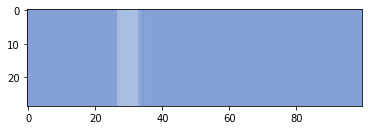

In [29]:
# resize the image
basewidth = 100
wpercent = (basewidth / float(img.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
img = img.resize((basewidth, hsize), Image.ANTIALIAS)
img = np.array(img)[:,:,:3]
print(img.shape)
plt.imshow(img)

In [30]:
img = img.reshape(-1,3)
img.shape

(2900, 3)

# Perform the segmentation task via Kmeans

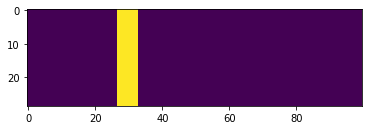

In [31]:
kmeans = KMeans(n_clusters=2).fit(img)
plt.imshow(kmeans.labels_.reshape(29,100))

# Perform the task via our algorithm

In [32]:
# generate graph from image
img = img.reshape(-1,3)/255
n_nodes=img.shape[0]
print("number of nodes:",n_nodes )

B,weight=get_B_and_weight_vec(n_nodes,0.2,1)
# plt.hist(weight,bins=30)  #distribution of similarity measure

number of nodes: 2900


In [33]:
def run_seg(n_nodes,seeds,threshold, K=30, alpha=0.1, lambda_nLasso=0.1):
    B, weight_vec = get_B_and_weight_vec(n_nodes,threshold)
    
    start = datetime.datetime.now()
    history = algorithm(B, weight_vec, seeds=seeds, K=K, alpha=alpha, lambda_nLasso=lambda_nLasso)
    print('our method time: ', datetime.datetime.now() - start)    
    return history

our method time:  0:00:00.431303


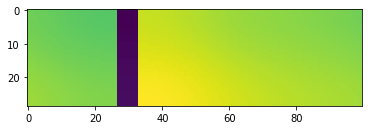

In [34]:
# generate seeds according to the labels assigned by kmeans
seeds = np.random.choice(np.where(kmeans.labels_==0)[0],20)

# run our algorithm  and visulize the result before feed it to kmeans
history = run_seg(n_nodes=n_nodes,seeds=seeds,threshold = 0.95, K=1000,alpha=0.01, lambda_nLasso=1)
plt.imshow(history[-1].reshape(29,100))

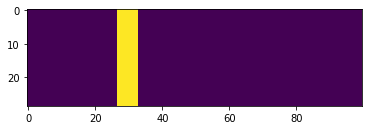

In [36]:
# Feed the node signal from our algorithm to kmeans to complete clustering (2 clusters)
history=np.nan_to_num(history)
kmeans = KMeans(n_clusters=2).fit(history[-1].reshape(len(history[-1]), 1))

#visulize the segmentation result
segmented = kmeans.labels_
plt.imshow(segmented.reshape((29,100)))

# Perform the segmentation task via spectral clustering

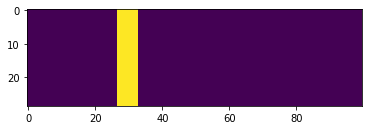

In [37]:
from sklearn.cluster import SpectralClustering

s=SpectralClustering(2).fit(img)

plt.imshow(s.labels_.reshape(29,100))

In [1]:
# Python3 Program to print BFS traversal
# from a given source vertex. BFS(int s)
# traverses vertices reachable from s.
from collections import defaultdict

# This class represents a directed graph
# using adjacency list representation
class Graph:

	# Constructor
	def __init__(self):

		# default dictionary to store graph
		self.graph = defaultdict(list)

	# function to add an edge to graph
	def addEdge(self,u,v):
		self.graph[u].append(v)

	# Function to print a BFS of graph
	def BFS(self, s):

		# Mark all the vertices as not visited
		visited = [False] * (max(self.graph) + 1)

		# Create a queue for BFS
		queue = []

		# Mark the source node as
		# visited and enqueue it
		queue.append(s)
		visited[s] = True

		while queue:

			# Dequeue a vertex from
			# queue and print it
			s = queue.pop(0)
			print (s, end = " ")

			# Get all adjacent vertices of the
			# dequeued vertex s. If a adjacent
			# has not been visited, then mark it
			# visited and enqueue it
			for i in self.graph[s]:
				if visited[i] == False:
					queue.append(i)
					visited[i] = True

# Driver code

# Create a graph given in
# the above diagram
g = Graph()
g.addEdge(0, 1)
g.addEdge(0, 2)
g.addEdge(1, 2)
g.addEdge(2, 0)
g.addEdge(2, 3)
g.addEdge(3, 3)

print ("Following is Breadth First Traversal"
				" (starting from vertex 2)")
g.BFS(2)

# This code is contributed by Neelam Yadav



Following is Breadth First Traversal (starting from vertex 2)
2 0 3 1 